In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image

In [58]:
import os

base_dir = 'images120'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [59]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=60,
                                    #  width_shift_range=0.2,
                                    #  height_shift_range=0.2,
                                    #  shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=30, 
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator(rescale=1./255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=30, 
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator

In [60]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 3600 images belonging to 30 classes.
Found 890 images belonging to 30 classes.


In [61]:
efficientnet = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
model = tf.keras.Sequential([
    hub.KerasLayer(efficientnet, trainable=False),  # Set trainable=False to keep the pre-trained weights fixed
])

In [62]:
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(30, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [63]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [64]:
callbacks = myCallback()
history = model.fit(train_generator,
                    steps_per_epoch=120,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/100
120/120 [==============================] - 250s 2s/step - loss: 0.5271 - accuracy: 0.8764 - val_loss: 0.1187 - val_accuracy: 0.9618
Epoch 2/100
120/120 [==============================] - 246s 2s/step - loss: 0.0814 - accuracy: 0.9761 - val_loss: 0.0877 - val_accuracy: 0.9685
Epoch 3/100
120/120 [==============================] - 234s 2s/step - loss: 0.0520 - accuracy: 0.9858 - val_loss: 0.0866 - val_accuracy: 0.9697
Epoch 4/100
120/120 [==============================] - 226s 2s/step - loss: 0.0441 - accuracy: 0.9889 - val_loss: 0.0614 - val_accuracy: 0.9753
Epoch 5/100
120/120 [==============================] - 175s 1s/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 0.0687 - val_accuracy: 0.9775
Epoch 6/100
120/120 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9956
Reached 99% accuracy so cancelling training!
120/120 [==============================] - 177s 1s/step - loss: 0.0189 - accuracy: 0.9956 - val_loss: 0.0739 - val_accuracy: 0.9742


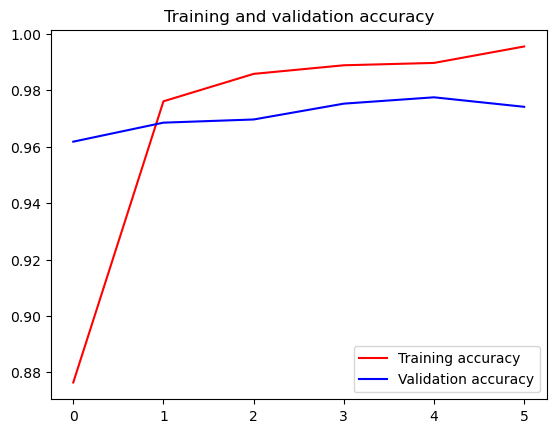

<Figure size 640x480 with 0 Axes>

In [65]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [79]:
# Specify the file path to save the model
model_path = 'model_cukup_bagus.h5'

# Save the model
model.save(model_path)

In [81]:
model_path2 = 'model_cukup_bagus2.h5'

tf.saved_model.save(model, model_path2)

INFO:tensorflow:Assets written to: model_cukup_bagus2.h5\assets


INFO:tensorflow:Assets written to: model_cukup_bagus2.h5\assets


In [77]:
testing_dir = os.path.join(base_dir, 'testing')

In [78]:
class_labels = ['alpukat','anggur','apel','bayam','brokoli','durian','jagung','jahe','jambu','jeruk','kembang kol',
                'kiwi','kol','lengkuas','lobak','mangga','melon','mentimun','naga','nanas','paprika',
                'pisang','salak','semangka','singkong','stroberi','terong','tomat','ubi jalar','wortel']

# Load and preprocess the image
for filename in os.listdir(testing_dir):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        img = image.load_img(os.path.join(testing_dir, filename), target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        predictions = model.predict(x)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_label = class_labels[predicted_class_index]
        print(f"The prediction of {filename} is {predicted_class_label} : {np.max(predictions[0])}")

The prediction of alpukat1.jpeg is alpukat : 0.9997022747993469
The prediction of alpukat2.jpg is alpukat : 0.9999421834945679
The prediction of alpukat3.jpg is alpukat : 0.9997923970222473
The prediction of anggur1.jpg is anggur : 0.9997580647468567
The prediction of anggur2.jpeg is anggur : 0.9912272095680237
The prediction of anggur3.jpg is anggur : 0.9998706579208374
The prediction of apel1.jpg is apel : 0.9989956021308899
The prediction of apel2.jpg is apel : 0.9993368983268738
The prediction of apel3.jpg is apel : 0.9871566891670227
The prediction of bayam1.jpeg is bayam : 0.9999990463256836
The prediction of bayam2.jpeg is bayam : 0.984567403793335
The prediction of bayam3.jpg is bayam : 0.9999768733978271
The prediction of brokoli1.jpg is brokoli : 0.9952630996704102
The prediction of brokoli2.jpg is brokoli : 0.9957883954048157
The prediction of brokoli3.jpg is brokoli : 0.9978939890861511
The prediction of durian1.jpg is durian : 0.9958038926124573
The prediction of durian2.j